In [1]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
import warnings
warnings.filterwarnings("ignore") #for ignoring the unnecessary warnings if any

In [3]:
#For parsing year column as date

def parser(x):
    return datetime.strptime(x,'%Y')

In [4]:
#Importing the dataset with Year column as index and removing 2030 and 2050 projection rows

df = pd.read_csv('mel_data_world.csv', header=0, parse_dates=[3], index_col=3, squeeze=True, date_parser=parser)[:-2]

In [5]:
df.tail()

,Area,Item,Element,Source,Unit,Value
Year,,,,,,
2015-01-01,World,All Animals,Emissions (CH4),FAO TIER 1,kilotonnes,97809.4203
2016-01-01,World,All Animals,Emissions (CH4),FAO TIER 1,kilotonnes,98853.5406
2017-01-01,World,All Animals,Emissions (CH4),FAO TIER 1,kilotonnes,99295.5717
2018-01-01,World,All Animals,Emissions (CH4),FAO TIER 1,kilotonnes,99918.7410
2019-01-01,World,All Animals,Emissions (CH4),FAO TIER 1,kilotonnes,100834.1659


In [6]:
#Excluding the columns that are not required

del df['Area']
del df['Item']
del df['Element']
del df['Source']
del df['Unit']

In [7]:
df.head()

,Value
Year,
1961-01-01,65345.0181
1962-01-01,66301.1211
1963-01-01,67010.1455
1964-01-01,67925.5358
1965-01-01,69192.9603


<AxesSubplot:xlabel='Year'>

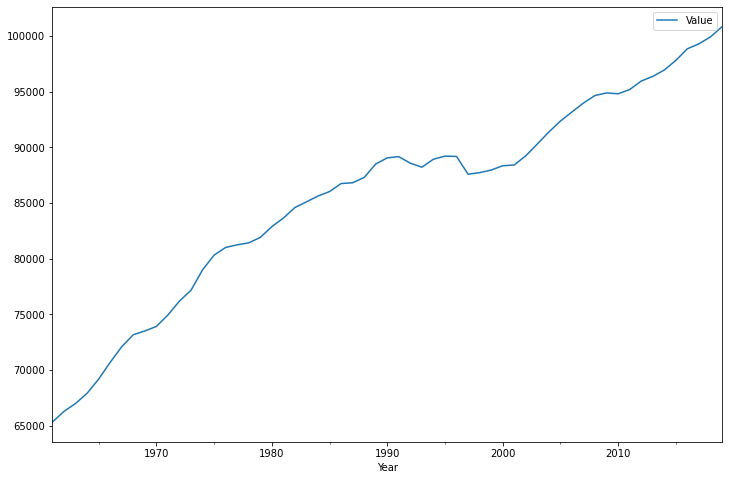

In [8]:
#intial plot
df.plot(figsize=(12, 8))

In [9]:
# To Check if the Time series is Stationary or not using Dickey-Fuller Test

def test_stat(ts):
    movingavg = ts.rolling(window=1).mean()
    movingstd = ts.rolling(window=1).std()
    
    original = plt.plot(ts, color='blue', label = 'Original')
    mean = plt.plot(movingavg, color='red', label = 'Rolling Mean')
    std = plt.plot(movingstd, color = 'black', label = 'Rolling Std deviation')
    plt.legend(loc = 'best')
    plt.title('Rolling mean and Std deviation')
    plt.show(block=False)
    
    print("Dickey fuller has been performed and the results are: ")
    out = adfuller(ts['Value'], autolag = 'AIC')
    op = pd.Series(out[0:4], index = ['Test-Statistic', 'p-value', 'Lags', 'Observations Used'])
    for key, value in out[4].items():
        op['Critical Value(%s)' %key] = value
    print(op)

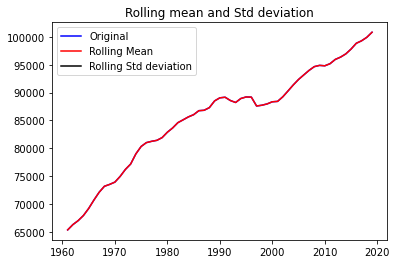

Dickey fuller has been performed and the results are: 
Test-Statistic         -1.531466
p-value                 0.517892
Lags                    1.000000
Observations Used      57.000000
Critical Value(1%)     -3.550670
Critical Value(5%)     -2.913766
Critical Value(10%)    -2.594624
dtype: float64


In [10]:
test_stat(df)

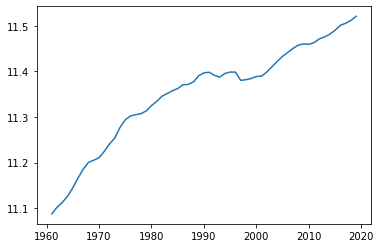

In [11]:
df_log = np.log(df)
plt.plot(df_log)

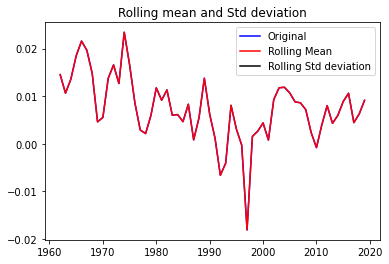

Dickey fuller has been performed and the results are: 
Test-Statistic         -3.704697
p-value                 0.004048
Lags                    0.000000
Observations Used      57.000000
Critical Value(1%)     -3.550670
Critical Value(5%)     -2.913766
Critical Value(10%)    -2.594624
dtype: float64


In [12]:
#1 order differencing

df_log_diff = df_log - df_log.shift()
df_log_diff.dropna(inplace=True)
test_stat(df_log_diff)

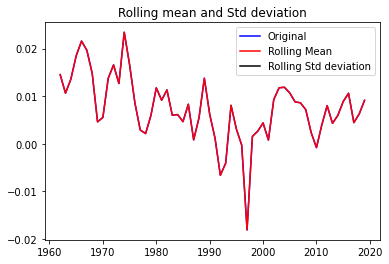

Dickey fuller has been performed and the results are: 
Test-Statistic         -3.704697
p-value                 0.004048
Lags                    0.000000
Observations Used      57.000000
Critical Value(1%)     -3.550670
Critical Value(5%)     -2.913766
Critical Value(10%)    -2.594624
dtype: float64


In [13]:
test_stat(df_log_diff)

Text(0.5, 1.0, 'ACF PLOT')

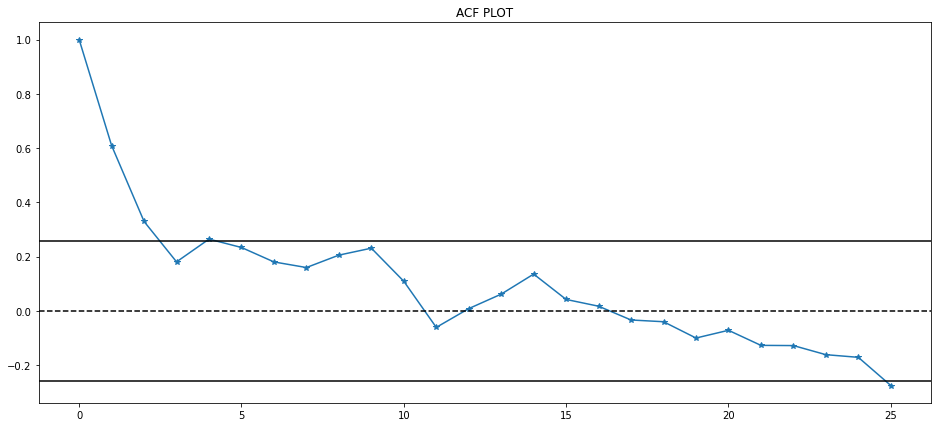

In [14]:
#ACF PLOT

lag_acf = acf(df_log_diff, nlags = 25, fft=False)
plt.figure(figsize=(16,7))
plt.plot(lag_acf,marker='*')
plt.axhline(y=0, linestyle='--',color = 'black')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='-', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='-', color='black')
plt.title('ACF PLOT')

Text(0.5, 1.0, 'PACF PLOT')

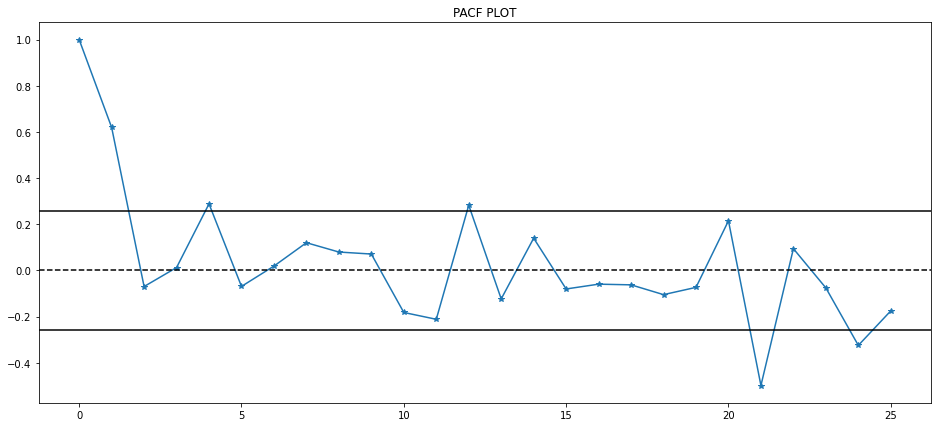

In [15]:
#PACF PLOT

lag_pacf = pacf(df_log_diff, nlags = 25)
plt.figure(figsize=(16,7))
plt.plot(lag_pacf,marker='*')
plt.axhline(y=0, linestyle='--',color = 'black')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='-', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='-', color='black')
plt.title('PACF PLOT')

In [16]:
# Dividing data into train and test

train = np.log(df.Value[:int(len(df)*.90)])
test = np.log(df.Value[len(train):])
print(len(train))
print(len(test))

53
6


In [17]:
# Preparing the model with order parameters 
#from tests and graphs for Yearly Data ('YS')

model = ARIMA(train, order=(3,1,2), freq = 'YS')

In [18]:
#Fitting the model with 

results = model.fit(disp = -1)

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Value   No. Observations:                   52
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 197.620
Method:                       css-mle   S.D. of innovations              0.005
Date:                Mon, 16 Aug 2021   AIC                           -381.240
Time:                        10:22:41   BIC                           -367.581
Sample:                    01-01-1962   HQIC                          -376.003
                         - 01-01-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0075      0.002      4.133      0.000       0.004       0.011
ar.L1.D.Value     0.4918      0.174      2.833      0.005       0.152       0.832
ar.L2.D.Value    -0.8177      0.156     -5.240      0.000      -1.124      -0.512
ar.L3.D.Value     0.4661      0.141      3.312      0.001       0.190       0.742
ma.L1.D.Value     0.2020      0.114      1.770      0.077      -0.022       0.426
ma.L2.D.Value     1.0000      0.120      8.361      0.000       0.766       1.234
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0337           -1.0847j            1.0853           -0.2549
AR.2           -0.0337           +1.0847j            1.0853            0.2549
AR.3            1.8216           -0.0000j            1.8216           -0.0000
MA.1           -0.1010           -0.9949j            1.0000           -0.2661
MA.2           -0.1010           +0.9949j            1.0000            0.2661
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'Original vs Fitting')

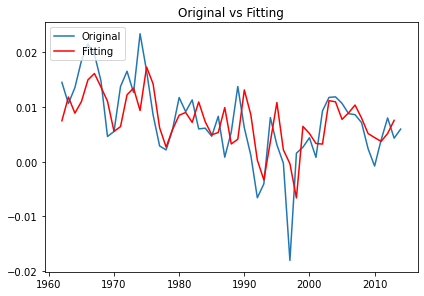

In [20]:
# Original vs Fitting graph

newdata = df_log_diff[0:len(train)]
plt.plot(newdata, label = 'Original')
plt.plot(results.fittedvalues, color='red', label = 'Fitting')
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.title('Original vs Fitting')

In [21]:
frcst, se, conf = results.forecast(len(test))

In [22]:
frcst_df = pd.Series(frcst, index = test.index)

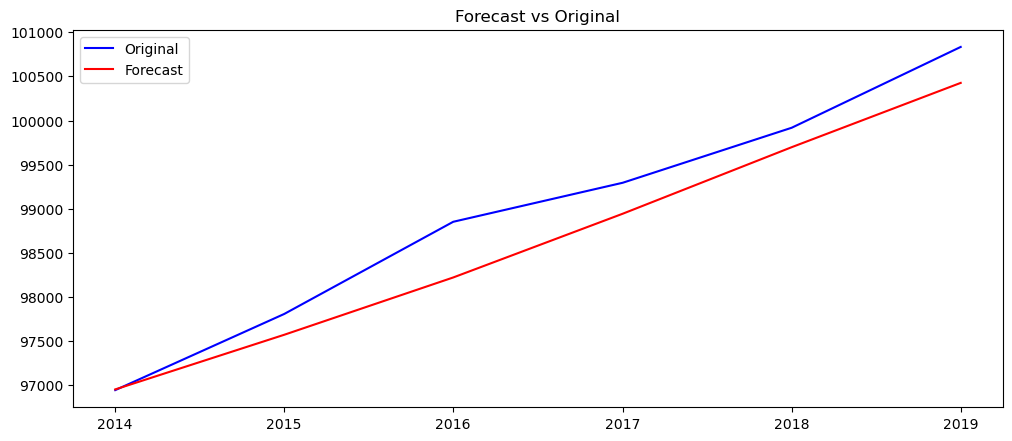

In [23]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.exp(test), label='Original', color='blue')
plt.plot(np.exp(frcst_df), label = 'Forecast', color='red')
plt.title('Forecast vs Original')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [24]:
# Calculating performance metrics

from math import sqrt
from sklearn import metrics

maeerror = sqrt(metrics.mean_absolute_error(test,frcst_df)) #calculate MAE
print('MAE value of the SVR Model is:', maeerror)
rmseerror = sqrt(metrics.mean_squared_error(test,frcst_df)) #calculate rmse
print('RMSE value of the SVR Model is:', rmseerror)
mapeerror = np.mean(np.abs((test - frcst_df) / test)) * 100
print('MAPE value of the SVR Model is:', mapeerror)

MAE value of the SVR Model is: 0.05581434540543053
RMSE value of the SVR Model is: 0.0036648975876581195
MAPE value of the SVR Model is: 0.02707414223888802


In [27]:
dftest = pd.read_csv('test_data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [28]:
dftest.head()

""
Year
2020-01-01
2021-01-01
2022-01-01
2023-01-01
2024-01-01


In [39]:
frcst_df = pd.Series(frcst, index = test.index)

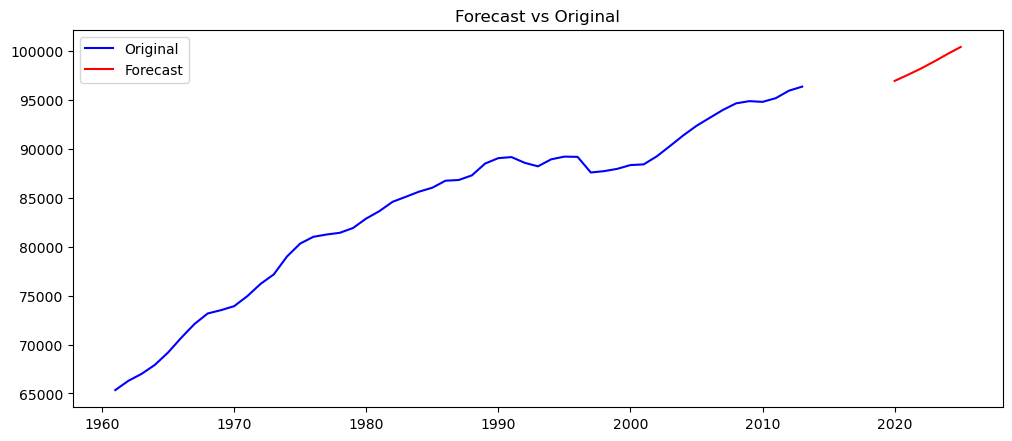

In [54]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.exp(train), label='Original', color='blue')
plt.plot(np.exp(frcst_dftest), label = 'Forecast', color='red')
plt.title('Forecast vs Original')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [43]:
frcst_dftest = pd.Series(frcst, index = dftest.index)

In [51]:
np.exp(frcst_dftest)

Year
2020-01-01     96954.699766
2021-01-01     97573.656653
2022-01-01     98222.732474
2023-01-01     98944.718937
2024-01-01     99698.583527
2025-01-01    100426.877821
dtype: float64